<a href="https://colab.research.google.com/github/danielTorren/out_of_our_minds_RL_ABM/blob/main/RL_ABM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First load in the ABM

In [ ]:
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gaussian_kde

First generate the reports for agents (this is in place of the actual reports that will be generated by BERTOPIC)

In [ ]:
def generate_dummy_real_world_reports(n_agents, m_topics, total_steps, focal_ids, adj_ids, filename="real_world_reports.npz"):
    """
    Generates a mock 'real world' dataset.
    Focal agents get a report for every timestep.
    Adjacent agents get a report only 20% of the time.
    """
    reports_db = {}

    for agent_id in range(n_agents):
        if agent_id in focal_ids:
            # Full history
            count = total_steps
        elif agent_id in adj_ids:
            # Sparse history (e.g., once every 5 steps)
            count = total_steps // 5
        else:
            continue

        # Generate random correlation matrices
        mats = []
        for _ in range(count):
            m = np.random.rand(m_topics, m_topics)
            m = (m + m.T) / 2
            np.fill_diagonal(m, 1.0)
            mats.append(m)

        reports_db[f"agent_{agent_id}"] = np.array(mats)

    os.makedirs("input_data", exist_ok=True)
    filepath = os.path.join("input_data", filename)
    np.savez_compressed(filepath, **reports_db)
    print(f"Dummy reports generated at: {filepath}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import networkx as nx
import random
import os
from datetime import datetime

# Set a consistent seed for reproducibility across environments
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ============================================================================
# SHARED POLICY NETWORKS
# ============================================================================

class PolicyNetworkWithInternal(nn.Module):
    """Policy network for agents that use internal reports (C, S, C_R)."""
    def __init__(self, M):
        super().__init__()
        self.M = M
        input_size = 3 * M * M  # C, S, C_R
        output_size = M * M
        hidden_size = int(input_size * 0.5)

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )
        self.scaling_factor = 0.005
        self.register_buffer("diagonal_mask", torch.ones(M, M))
        for i in range(M):
            self.diagonal_mask[i, i] = 0

    def forward(self, x):
        delta_C_flat = self.net(x)
        delta_C = delta_C_flat.view(-1, self.M, self.M) * self.scaling_factor
        delta_C = delta_C * self.diagonal_mask
        return delta_C


class PolicyNetworkWithoutInternal(nn.Module):
    """Policy network for agents that only use social input (C, S)."""
    def __init__(self, M):
        super().__init__()
        self.M = M
        input_size = 2 * M * M  # Only C and S
        output_size = M * M
        hidden_size = int(input_size * 0.5)

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )
        self.scaling_factor = 0.005
        self.register_buffer("diagonal_mask", torch.ones(M, M))
        for i in range(M):
            self.diagonal_mask[i, i] = 0

    def forward(self, x):
        delta_C_flat = self.net(x)
        delta_C = delta_C_flat.view(-1, self.M, self.M) * self.scaling_factor
        delta_C = delta_C * self.diagonal_mask
        return delta_C


# ============================================================================
# AGENT CLASSES
# ============================================================================

class BaseAgent:
    """Utility methods shared across all agents."""
    def _to_tensor(self, data, requires_grad=False):
        return torch.as_tensor(data, dtype=torch.float32).clone().detach().requires_grad_(requires_grad)

    def _update_policy(self, loss_tensor):
        self.optimizer.zero_grad()
        loss_tensor.backward()
        self.optimizer.step()

class FocalAgent(BaseAgent):
    """Focal agent: Generates internal reports EVERY time step."""
    def __init__(self, agent_id, M, initial_C_np, lambda_weight=0.5, learning_rate=0.001, seed=None):
        self.id = agent_id
        self.M = M
        self.agent_type = "FOCAL"
        self.lambda_weight = lambda_weight
        self.C = self._to_tensor(initial_C_np)
        self.report_count = 0

        if seed is not None:
            torch.manual_seed(int(seed))

        self.policy = PolicyNetworkWithInternal(M)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.d_ext = torch.tensor(0.0)
        self.d_int = torch.tensor(0.0)

    def step(self, S_social_np, C_R_report_np):
        S_social = self._to_tensor(S_social_np)
        C_R_report = self._to_tensor(C_R_report_np)
        self.report_count += 1

        d_ext_prev, d_int_prev = self.d_ext.detach(), self.d_int.detach()
        C_current_grad = self.C.detach().clone().requires_grad_(True)

        state_input = torch.cat([C_current_grad.flatten(), S_social.flatten(), C_R_report.flatten()]).unsqueeze(0)
        delta_C = self.policy(state_input).squeeze(0)

        C_new_calc = C_current_grad + delta_C
        C_new_calc = (C_new_calc + C_new_calc.T) / 2
        for i in range(self.M): C_new_calc[i, i] = 1.0
        C_new_calc = torch.clamp(C_new_calc, -5, 5)

        d_ext_new = torch.linalg.norm(C_new_calc - S_social, ord='fro')
        d_int_new = torch.linalg.norm(C_new_calc - C_R_report, ord='fro')
        d_ext_topic_vector = torch.sum(torch.abs(C_new_calc - S_social), dim=1)

        reward = (self.lambda_weight * d_int_prev + (1 - self.lambda_weight) * d_ext_prev) - \
                 (self.lambda_weight * d_int_new + (1 - self.lambda_weight) * d_ext_new)

        self._update_policy(-reward)

        self.C, self.d_ext, self.d_int = C_new_calc.detach(), d_ext_new.detach(), d_int_new.detach()
        return self.C.numpy(), self.d_ext.item(), self.d_int.item(), reward.item(), d_ext_topic_vector.detach().numpy()


class FocalAdjacentAgent(BaseAgent):
    """Focal-adjacent agent: Generates internal reports every X time steps."""
    def __init__(self, agent_id, M, initial_C_np, internal_noise_std, lambda_weight=0.5, learning_rate=0.001, seed=None):
        self.id = agent_id
        self.M = M
        self.agent_type = "FOCAL_ADJACENT"
        self.internal_noise_std = internal_noise_std
        self.lambda_weight = lambda_weight
        self.C = self._to_tensor(initial_C_np)
        self.store_C_R_report = self.C.clone().detach()
        self.last_report_time = -1
        self.report_count = 0

        if seed is not None:
            torch.manual_seed(int(seed))

        self.policy = PolicyNetworkWithInternal(M)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.d_ext = torch.tensor(0.0)
        self.d_int = torch.tensor(0.0)

    def should_generate_report(self, current_time, report_interval):
        if (current_time - self.last_report_time) >= report_interval:
            self.last_report_time = current_time
            return True
        return False

    def step(self, S_social_np, C_R_report_np=None, generate_report=True):
        S_social = self._to_tensor(S_social_np)

        if generate_report and C_R_report_np is not None:
            C_R_report = self._to_tensor(C_R_report_np)
            self.store_C_R_report = C_R_report.clone().detach()
            self.report_count += 1
        else:
            noise = torch.randn_like(self.store_C_R_report) * self.internal_noise_std
            noise.fill_diagonal_(0)
            C_R_report = torch.clamp(self.store_C_R_report + noise, 0, 1)

        d_ext_prev, d_int_prev = self.d_ext.detach(), self.d_int.detach()
        C_current_grad = self.C.detach().clone().requires_grad_(True)

        state_input = torch.cat([C_current_grad.flatten(), S_social.flatten(), C_R_report.flatten()]).unsqueeze(0)
        delta_C = self.policy(state_input).squeeze(0)

        C_new_calc = C_current_grad + delta_C
        C_new_calc = (C_new_calc + C_new_calc.T) / 2
        for i in range(self.M): C_new_calc[i, i] = 1.0
        C_new_calc = torch.clamp(C_new_calc, -5, 5)

        d_ext_new = torch.linalg.norm(C_new_calc - S_social, ord='fro')
        d_int_new = torch.linalg.norm(C_new_calc - C_R_report, ord='fro')
        d_ext_topic_vector = torch.sum(torch.abs(C_new_calc - S_social), dim=1)

        reward = (self.lambda_weight * d_int_prev + (1 - self.lambda_weight) * d_ext_prev) - \
                 (self.lambda_weight * d_int_new + (1 - self.lambda_weight) * d_ext_new)

        self._update_policy(-reward)

        self.C, self.d_ext, self.d_int = C_new_calc.detach(), d_ext_new.detach(), d_int_new.detach()
        return self.C.numpy(), self.d_ext.item(), self.d_int.item(), reward.item(), d_ext_topic_vector.detach().numpy()


class NonFocalAgent(BaseAgent):
    """Non-focal agent: NEVER generates internal reports, only social learning."""
    def __init__(self, agent_id, M, initial_C_np, learning_rate=0.001, seed=None):
        self.id = agent_id
        self.M = M
        self.agent_type = "NON_FOCAL"
        self.C = self._to_tensor(initial_C_np)
        self.report_count = 0

        if seed is not None:
            torch.manual_seed(int(seed))

        self.policy = PolicyNetworkWithoutInternal(M)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.d_ext = torch.tensor(0.0)
        self.d_int = torch.tensor(0.0)

    def step(self, S_social_np):
        S_social = self._to_tensor(S_social_np)
        d_ext_prev = self.d_ext.detach()
        C_current_grad = self.C.detach().clone().requires_grad_(True)

        state_input = torch.cat([C_current_grad.flatten(), S_social.flatten()]).unsqueeze(0)
        delta_C = self.policy(state_input).squeeze(0)

        C_new_calc = C_current_grad + delta_C
        C_new_calc = (C_new_calc + C_new_calc.T) / 2
        for i in range(self.M): C_new_calc[i, i] = 1.0
        C_new_calc = torch.clamp(C_new_calc, -5, 5)

        d_ext_new = torch.linalg.norm(C_new_calc - S_social, ord='fro')
        d_ext_topic_vector = torch.sum(torch.abs(C_new_calc - S_social), dim=1)
        reward = d_ext_prev - d_ext_new

        self._update_policy(-reward)

        self.C, self.d_ext = C_new_calc.detach(), d_ext_new.detach()
        return self.C.numpy(), self.d_ext.item(), 0.0, reward.item(), d_ext_topic_vector.detach().numpy()


# ============================================================================
# ENVIRONMENT CLASS
# ============================================================================
class ABMEnvironment:
    def __init__(self, N=100, M=5, k_neighbors=5, social_noise_std=0.1,
                 internal_noise_std=0.05, lambda_weight=0.5, learning_rate=0.001,
                 focal_percentage=0.1, report_interval=5, pre_generated_reports=None):
        """
        Args:
            pre_generated_reports: Matrix of shape (Time_Steps, Num_Focal_Agents, M, M)
        """
        self.N = N
        self.M = M
        self.k_neighbors = k_neighbors
        self.social_noise_std = social_noise_std
        self.internal_noise_std = internal_noise_std
        self.lambda_weight = lambda_weight
        self.learning_rate = learning_rate
        self.focal_percentage = focal_percentage
        self.report_interval = report_interval

        # This is the list of matrices you generated beforehand
        self.pre_generated_reports = pre_generated_reports

        self.time_step = 0
        self.agents = []
        self._initialize_environment()

    def _initialize_environment(self):
        # Create the social network
        self.social_network = nx.watts_strogatz_graph(n=self.N, k=self.k_neighbors, p=0.05, seed=42)
        self.adj_matrix = nx.to_numpy_array(self.social_network)

        # 1. Identify Focal Agents
        num_focal = int(self.N * self.focal_percentage)
        self.focal_agents = random.sample(range(self.N), num_focal)

        # Mapping global ID to an index (0 to num_focal-1) to pull from the report list
        self.focal_id_to_idx = {f_id: idx for idx, f_id in enumerate(self.focal_agents)}

        # 2. Identify Focal-Adjacent (neighbors of focal agents)
        self.focal_adjacent_agents = set()
        for focal_id in self.focal_agents:
            neighbors = np.where(self.adj_matrix[focal_id] == 1)[0]
            for n_id in neighbors:
                if n_id not in self.focal_agents:
                    self.focal_adjacent_agents.add(n_id)
        self.focal_adjacent_agents = list(self.focal_adjacent_agents)

        # 3. Identify Non-Focal
        all_agents = set(range(self.N))
        self.non_focal_agents = list(all_agents - set(self.focal_agents) - set(self.focal_adjacent_agents))

        # 4. Instantiate Agents
        self.agents = [None] * self.N
        for i in range(self.N):
            # Shared initial random state for C
            init_C = np.random.rand(self.M, self.M)
            init_C = (init_C + init_C.T) / 2
            np.fill_diagonal(init_C, 1.0)

            if i in self.focal_agents:
                self.agents[i] = FocalAgent(i, self.M, init_C, self.lambda_weight, self.learning_rate, i)
            elif i in self.focal_adjacent_agents:
                self.agents[i] = FocalAdjacentAgent(i, self.M, init_C, self.internal_noise_std, self.lambda_weight, self.learning_rate, i)
            else:
                self.agents[i] = NonFocalAgent(i, self.M, init_C, self.learning_rate, i)

    def _calculate_social_input(self, agent_id):
        neighbors = np.where(self.adj_matrix[agent_id] == 1)[0]
        if len(neighbors) == 0:
            return np.zeros((self.M, self.M))

        selected = random.sample(list(neighbors), random.randint(int(len(neighbors)*0.3)+1, len(neighbors)))
        sum_C = np.zeros((self.M, self.M))

        for j in selected:
            C_j = self.agents[j].C.numpy()
            noise = np.random.normal(0, self.social_noise_std, (self.M, self.M))
            np.fill_diagonal(noise, 0)
            sum_C += np.clip(C_j + noise, 0, 1)

        return sum_C / len(selected)

    def step_simulation(self):
        t = self.time_step

        # Lists for tracking current step data
        step_results = []
        current_C_matrices = []

        for i, agent in enumerate(self.agents):
            S_it = self._calculate_social_input(i)

            if isinstance(agent, FocalAgent):
                # Pull from pre-generated list using local index
                focal_idx = self.focal_id_to_idx[agent.id]
                C_R_it = self.pre_generated_reports[t, focal_idx]
                res = agent.step(S_it, C_R_it)

            elif isinstance(agent, FocalAdjacentAgent):
                gen = agent.should_generate_report(t, self.report_interval)
                C_R_it = None
                if gen:
                    # Logic: If they observe a report, they pull from their specific neighbor's pre-gen data
                    # For simplicity, we look up the report of the first focal agent they are connected to
                    neighbor_focals = [f for f in self.focal_agents if self.adj_matrix[agent.id, f] == 1]
                    if neighbor_focals:
                        obs_idx = self.focal_id_to_idx[neighbor_focals[0]]
                        C_R_it = self.pre_generated_reports[t, obs_idx]

                res = agent.step(S_it, C_R_it, gen)

            else: # NonFocalAgent
                res = agent.step(S_it)

            step_results.append(res)
            current_C_matrices.append(res[0])

        self.time_step += 1

        # Package metrics for history
        return self._package_metrics(step_results, current_C_matrices)

    def _package_metrics(self, step_results, current_C_matrices):
        # Extracts d_ext, d_int, reward, and topic_vector from the step_results tuples
        d_ext_vals = [r[1] for r in step_results]
        d_int_vals = [r[2] for r in step_results]
        rewards = [r[3] for r in step_results]

        return {
            'time': self.time_step,
            'd_ext_avg': np.mean(d_ext_vals),
            'd_int_avg': np.mean(d_int_vals),
            'reward_avg': np.mean(rewards),
            'C_matrices': np.stack(current_C_matrices),
            'topic_vectors': [r[4] for r in step_results]
        }

def run_simulation_from_file(report_file_path, N_AGENTS=100, M_TOPICS=5,
                             K_NEIGHBORS=6, REPORT_INTERVAL=5, LEARNING_RATE=0.001):
    """
    Loads pre-generated reports and runs the simulation based on the length
    of the report sequence.
    """
    # Load reports
    # Expected format: .npz file with a 'reports' key
    data = np.load(report_file_path)
    loaded_reports = data['reports'] # Shape: (Time, Num_Focal, M, M)

    total_steps = loaded_reports.shape[0]
    num_focal_in_file = loaded_reports.shape[1]

    # Calculate focal percentage based on the report file structure
    focal_pct = num_focal_in_file / N_AGENTS

    print(f"Starting simulation for {total_steps} steps...")
    print(f"Focal Agents: {num_focal_in_file} ({focal_pct*100:.1f}%)")

    env = ABMEnvironment(
        N=N_AGENTS,
        M=M_TOPICS,
        k_neighbors=K_NEIGHBORS,
        focal_percentage=focal_pct,
        report_interval=REPORT_INTERVAL,
        learning_rate=LEARNING_RATE,
        pre_generated_reports=loaded_reports
    )

    history = []
    for t in range(total_steps):
        metrics = env.step_simulation()
        history.append(metrics)
        if t % 10 == 0:
            print(f"Step {t} complete. Avg D_ext: {metrics['d_ext_avg']:.4f}")

    # Save output
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = f"output_data/sim_results_{timestamp}.npz"
    os.makedirs("output_data", exist_ok=True)

    np.savez_compressed(output_path,
                        d_ext_avg=np.array([h['d_ext_avg'] for h in history]),
                        reward_avg=np.array([h['reward_avg'] for h in history]))

    print(f"Simulation finished. Results saved to {output_path}")
    return history, env

In [ ]:
%who

ABMEnvironment	 FocalAdjacentAgent	 FocalAgent	 NonFocalAgent	 PolicyNetworkWithInternal	 PolicyNetworkWithoutInternal	 SEED	 datetime	 nn	 
np	 nx	 optim	 os	 random	 run_simulation	 time	 torch	 


Now run the ABM, saving the data into output_data

In [ ]:
def main():

    SEED = 42
    N_AGENTS = 100
    M_TOPICS = 10
    K_NEIGHBORS = 6
    LAMBDA_WEIGHT = 0.5
    LEARNING_RATE = 0.001
    SIMULATION_STEPS = 40
    SOCIAL_NOISE = 0.05
    INTERNAL_NOISE = 0.05
    FOCAL_PERCENTAGE=0.2  # 20% focal agents
    REPORT_INTERVAL=3     # Focal-adjacent agents report every 3 steps

    # Run the simulation and save data
    history, env, C_filepath = run_simulation(
        SEED=SEED,
        N_AGENTS=N_AGENTS,
        M_TOPICS=M_TOPICS,
        K_NEIGHBORS=K_NEIGHBORS,
        LAMBDA_WEIGHT=LAMBDA_WEIGHT,
        LEARNING_RATE=LEARNING_RATE,
        SIMULATION_STEPS=SIMULATION_STEPS,
        SOCIAL_NOISE=SOCIAL_NOISE,
        INTERNAL_NOISE=INTERNAL_NOISE,
        FOCAL_PERCENTAGE = FOCAL_PERCENTAGE,
        REPORT_INTERVAL= REPORT_INTERVAL,

        save_data=True
    )
    print("FILE PATH: ", C_filepath)

if __name__ == "__main__":
    main()

Initializing ABM with 100 agents and 10 meta-topics
Focal agents: 20.0% of population
Report interval for focal-adjacent agents: 3 time steps

Agent Type Distribution:
Focal agents: 20
Focal-adjacent agents: 61
Non-focal agents: 19
Simulation saved to: output_data/separate_agents_run_20251216_101636.npz
FILE PATH:  output_data/separate_agents_run_20251216_101636.npz


**Plotting: Now load in the data from output_data and plot the results**

Imports and Data Loading Function

In [ ]:
import numpy as np
import os

def load_simulation_data(filepath):
    """
    Load simulation data from the specified file path, including topic vectors.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    print(f"Loading simulation data from: {filepath}")

    # Load main data - allow_pickle is required for the object arrays
    data = np.load(filepath, allow_pickle=True)

    # Try to load C matrices from corresponding file (logic remains same)
    base_name = filepath.replace('.npz', '')
    C_filepath = f"{base_name}_C_matrices.npz"

    if os.path.exists(C_filepath):
        C_data = np.load(C_filepath, allow_pickle=True)
        C_matrices_history = C_data['C_matrices']
    else:
        print("Warning: C matrices file not found. Some plots will be unavailable.")
        C_matrices_history = None

    # Reconstruct history
    history = []
    num_steps = len(data['timesteps'])

    for i in range(num_steps):
        history_entry = {
            'time': data['timesteps'][i],
            'd_ext_avg': data['d_ext_avg_history'][i],
            'd_int_avg': data['d_int_avg_history'][i],
            'reward_avg': data['reward_history'][i],
            # Reconstruct individual histories (N_agents, Time) -> (N_agents,) at this step
            'd_ext_individual': data['d_ext_individual_history'][:, i],
            'd_int_individual': data['d_int_individual_history'][:, i],
        }

        # --- Reconstruct Topic Vectors ---
        # These are saved as Time-indexed object arrays
        if 'focal_topic_vector_history' in data:
            history_entry['focal_d_ext_topic_vector'] = data['focal_topic_vector_history'][i]

        if 'focal_adjacent_topic_vector_history' in data:
            history_entry['focal_adjacent_d_ext_topic_vector'] = data['focal_adjacent_topic_vector_history'][i]

        if 'non_focal_topic_vector_history' in data:
            history_entry['non_focal_d_ext_topic_vector'] = data['non_focal_topic_vector_history'][i]

        # --- Reconstruct Agent Type Averages ---
        # Map back to the keys used in your plotting functions
        type_mapping = {
            'focal_d_ext_history': 'focal_d_ext_avg',
            'focal_d_int_history': 'focal_d_int_avg',
            'focal_adjacent_d_ext_history': 'focal_adjacent_d_ext_avg',
            'focal_adjacent_d_int_history': 'focal_adjacent_d_int_avg',
            'non_focal_d_ext_history': 'non_focal_d_ext_avg',
            'non_focal_d_int_history': 'non_focal_d_int_avg'
        }

        for save_key, entry_key in type_mapping.items():
            if save_key in data:
                history_entry[entry_key] = data[save_key][i]

        # Reconstruct C Matrices
        if C_matrices_history is not None and i < len(C_matrices_history):
            history_entry['C_matrices'] = C_matrices_history[i]

        history.append(history_entry)

    # Load parameters and agent metadata
    parameters = data['parameters'].item() if 'parameters' in data else {}

    agent_info = {}
    for key in ['focal_agents', 'focal_adjacent_agents', 'non_focal_agents']:
        if key in data:
            agent_info[key] = data[key]

    return history, parameters, agent_info

Load Data

In [ ]:
# Load your simulation data - update the file path as needed
file_path = "output_data/separate_agents_run_20251216_101636.npz"#"output_data/single_run_20251128_125859.npz"
history, parameters, agent_info = load_simulation_data(file_path)

print(f"Loaded simulation data with parameters:")
for key, value in parameters.items():
    if key != 'timestamp':
        print(f"  {key}: {value}")

if 'timestamp' in parameters:
    print(f"  Simulation run: {parameters['timestamp']}")

# Print summary
if history:
    initial_step = history[0]
    final_step = history[-1]
    print("\n--- Final Dissonance Analysis ---")
    print(f"Initial Avg External Dissonance: {initial_step['d_ext_avg']:.4f}")
    print(f"Final Avg External Dissonance:   {final_step['d_ext_avg']:.4f}")
    print(f"Initial Avg Internal Dissonance: {initial_step['d_int_avg']:.4f}")
    print(f"Final Avg Internal Dissonance:   {final_step['d_int_avg']:.4f}")

Loading simulation data from: output_data/separate_agents_run_20251216_101636.npz
Loaded simulation data with parameters:
  SEED: 42
  N_AGENTS: 100
  M_TOPICS: 10
  K_NEIGHBORS: 6
  LAMBDA_WEIGHT: 0.5
  LEARNING_RATE: 0.001
  SIMULATION_STEPS: 40
  SOCIAL_NOISE: 0.05
  INTERNAL_NOISE: 0.05
  FOCAL_PERCENTAGE: 0.2
  REPORT_INTERVAL: 3
  Simulation run: 20251216_101636

--- Final Dissonance Analysis ---
Initial Avg External Dissonance: 2.1895
Final Avg External Dissonance:   1.8973
Initial Avg Internal Dissonance: 0.3575
Final Avg Internal Dissonance:   0.4738


Figure 0 - Dissonance vector

/tmp/ipython-input-2302339755.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot([final_step_data[:, i] for i in range(M)], labels=[f'T{i+1}' for i in range(M)])


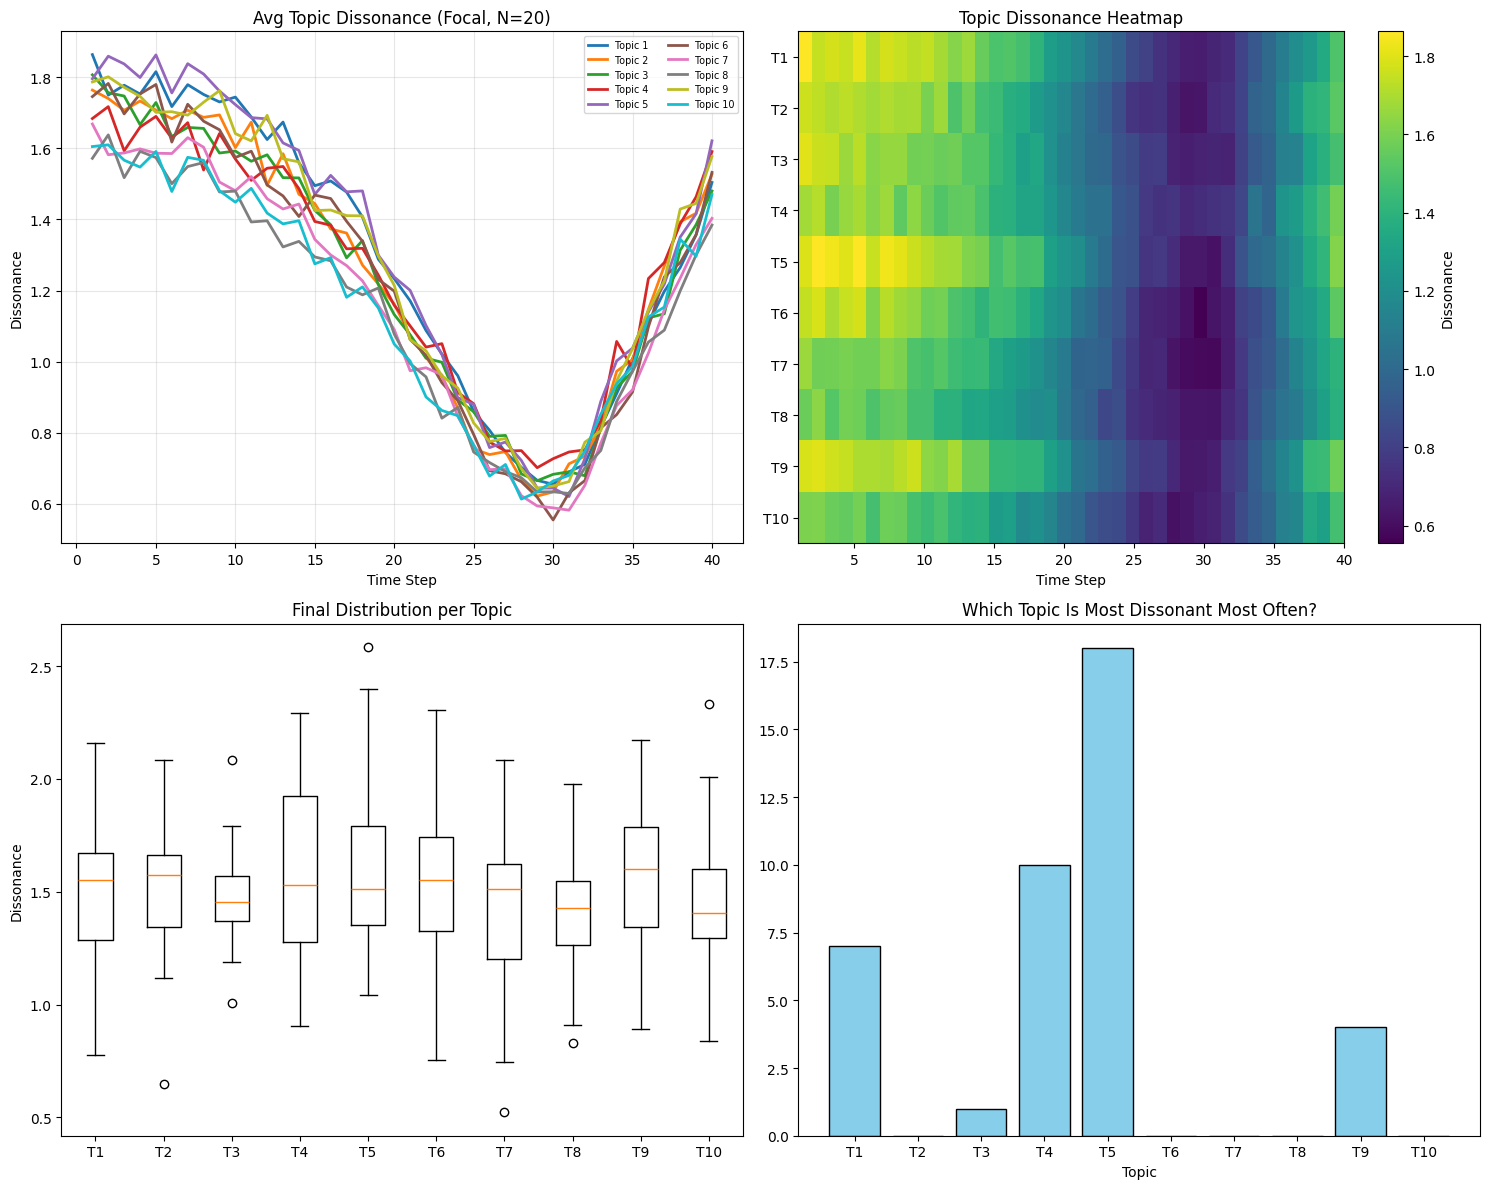

In [ ]:
def plot_d_ext_topic_vector_evolution_from_file(history, parameters, agent_info, figsize=(15, 12)):
    """
    Fixed version to handle the ValueError in axis labeling.
    """
    # 1. Check for focal agents
    if 'focal_agents' not in agent_info or len(agent_info['focal_agents']) == 0:
        print("Warning: No focal agent data found.")
        return

    # 2. Setup Dimensions
    timesteps = [d['time'] for d in history]
    num_focal = len(agent_info['focal_agents'])
    M = parameters.get('M_TOPICS', 5)

    # 3. Process Topic Vector Data strictly into a Float Array
    all_focal_topic_vectors = []
    valid_timesteps = []

    for t, step_data in enumerate(history):
        if 'focal_d_ext_topic_vector' in step_data:
            vecs = step_data['focal_d_ext_topic_vector']
            try:
                # Convert object/list data to concrete float array
                float_vecs = np.array(vecs, dtype=np.float64)
                if float_vecs.shape == (num_focal, M):
                    all_focal_topic_vectors.append(float_vecs)
                    valid_timesteps.append(timesteps[t])
            except (ValueError, TypeError):
                continue

    if not all_focal_topic_vectors:
        print("Error: Could not extract valid numeric topic vectors.")
        return

    # Convert to 3D Float Array: (Time, Agents, Topics)
    all_focal_topic_vectors = np.stack(all_focal_topic_vectors).astype(np.float64)
    avg_topic_vectors = np.mean(all_focal_topic_vectors, axis=1) # (Time, M)

    # ============================================================================
    # PLOTTING
    # ============================================================================
    fig = plt.figure(figsize=figsize)

    # Plot 1: Lines
    ax1 = plt.subplot(2, 2, 1)
    for topic_idx in range(M):
        ax1.plot(valid_timesteps, avg_topic_vectors[:, topic_idx], label=f'Topic {topic_idx+1}', linewidth=2)
    ax1.set_title(f'Avg Topic Dissonance (Focal, N={num_focal})')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Dissonance')
    ax1.legend(loc='best', fontsize='x-small', ncol=2)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Heatmap - FIXED TICK LOGIC
    ax2 = plt.subplot(2, 2, 2)
    im = ax2.imshow(avg_topic_vectors.T, aspect='auto', cmap='viridis',
                    extent=[valid_timesteps[0], valid_timesteps[-1], M + 0.5, 0.5])

    # FIX: Ensure locations and labels match exactly
    tick_locations = np.arange(1, M + 1)
    ax2.set_yticks(tick_locations)
    ax2.set_yticklabels([f'T{i}' for i in tick_locations])

    ax2.set_title('Topic Dissonance Heatmap')
    ax2.set_xlabel('Time Step')
    plt.colorbar(im, ax=ax2, label='Dissonance')

    # Plot 4: Boxplot
    ax4 = plt.subplot(2, 2, 3)
    final_step_data = all_focal_topic_vectors[-1] # (N, M)
    ax4.boxplot([final_step_data[:, i] for i in range(M)], labels=[f'T{i+1}' for i in range(M)])
    ax4.set_title('Final Distribution per Topic')
    ax4.set_ylabel('Dissonance')

    # Plot 5: Dominance Histogram
    ax5 = plt.subplot(2, 2, 4)
    dominant_topics = np.argmax(avg_topic_vectors, axis=1)
    ax5.hist(dominant_topics + 1, bins=np.arange(1, M + 2) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
    ax5.set_xticks(range(1, M + 1))
    ax5.set_xticklabels([f'T{i}' for i in range(1, M+1)])
    ax5.set_title('Which Topic Is Most Dissonant Most Often?')
    ax5.set_xlabel('Topic')

    plt.tight_layout()
    plt.show()

plot_d_ext_topic_vector_evolution_from_file(history, parameters, agent_info)

Figure 1 - Focal Agents Dissonance and Reward

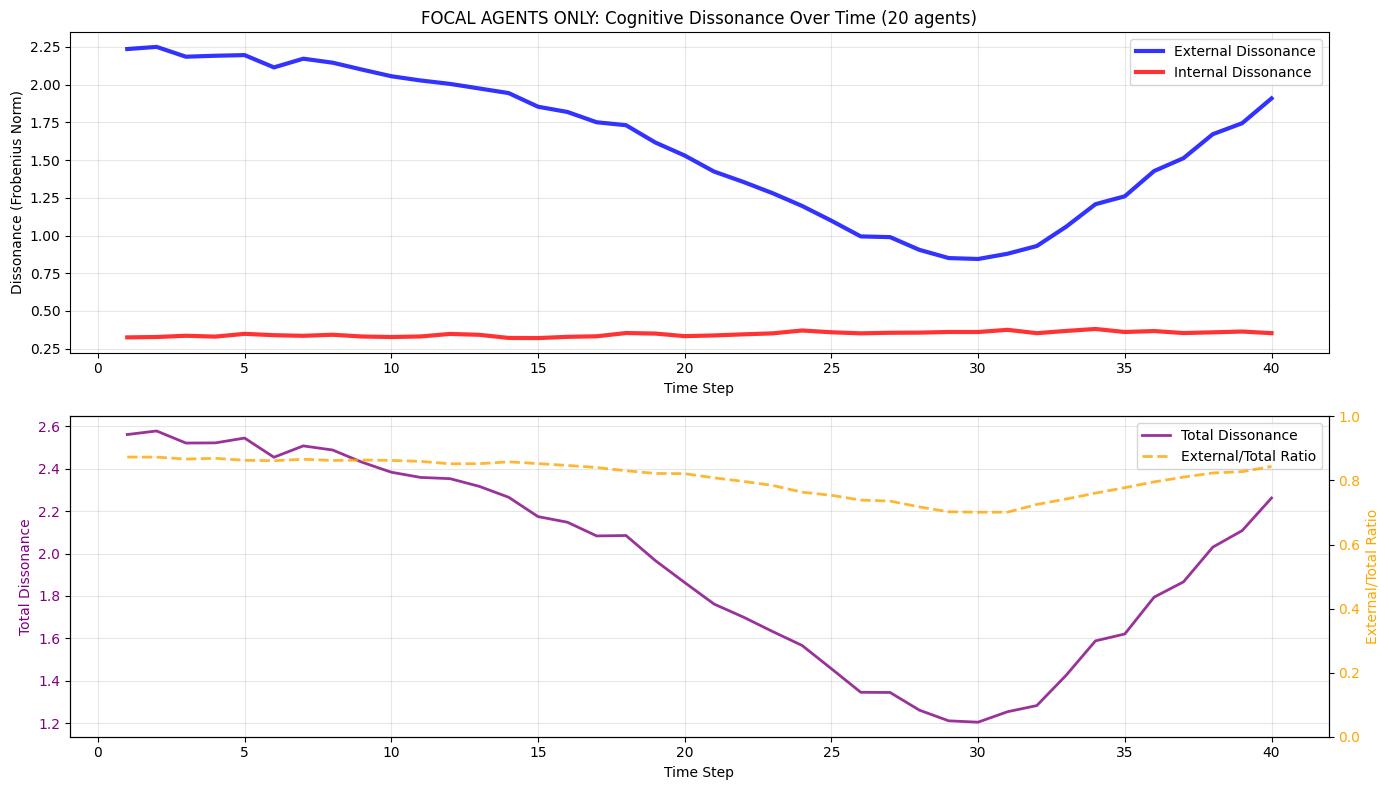

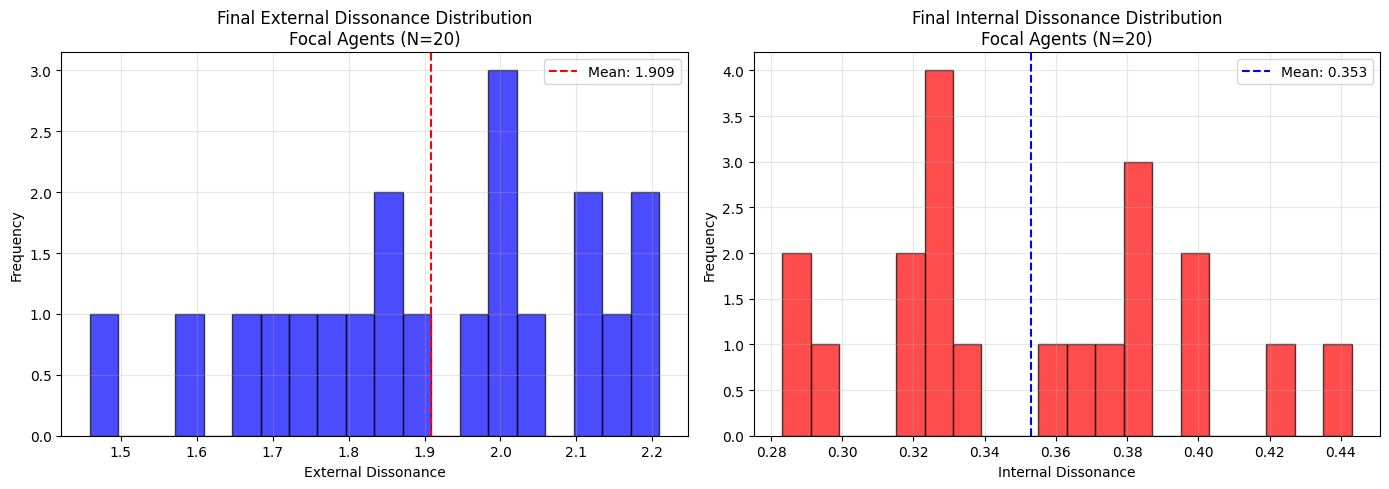

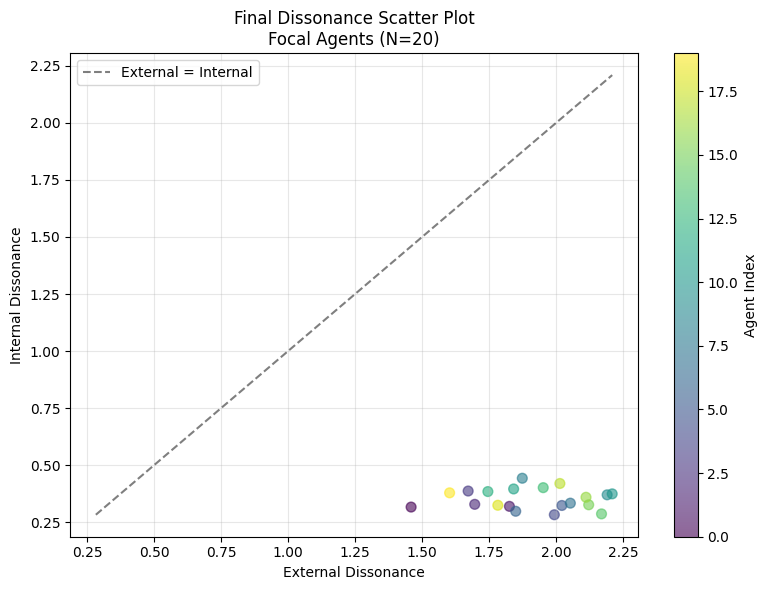

In [ ]:
def plot_focal_agents_dissonance(history, parameters, agent_info):
    """
    Plot focal agents only.
    """
    if 'focal_d_ext_avg' not in history[0]:
        print("Warning: No focal agent data found in history. Cannot plot focal agents only.")
        return

    timesteps = [d['time'] for d in history]
    focal_d_ext_history = [d['focal_d_ext_avg'] for d in history]
    focal_d_int_history = [d['focal_d_int_avg'] for d in history]

    # Get number of focal agents from agent_info if available, otherwise estimate
    if agent_info and 'focal_agents' in agent_info:
        num_focal = len(agent_info['focal_agents'])
    elif 'focal_percentage' in parameters and 'N_AGENTS' in parameters:
        num_focal = int(parameters['N_AGENTS'] * parameters['focal_percentage'])
    else:
        num_focal = "unknown"

    # Plot 1: Focal Agents Dissonance Over Time
    fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    # Top plot: Dissonance values
    ax1.plot(timesteps, focal_d_ext_history, label='External Dissonance',
             color='blue', linewidth=3, alpha=0.8)
    ax1.plot(timesteps, focal_d_int_history, label='Internal Dissonance',
             color='red', linewidth=3, alpha=0.8)
    ax1.set_title(f'FOCAL AGENTS ONLY: Cognitive Dissonance Over Time ({num_focal} agents)')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Dissonance (Frobenius Norm)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Bottom plot: Total dissonance and ratio
    focal_total_history = [ext + int for ext, int in zip(focal_d_ext_history, focal_d_int_history)]
    focal_ratio_history = [ext/(ext+int) if (ext+int) > 0 else 0
                          for ext, int in zip(focal_d_ext_history, focal_d_int_history)]

    ax2.plot(timesteps, focal_total_history, label='Total Dissonance',
             color='purple', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Total Dissonance', color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')
    ax2.grid(True, alpha=0.3)

    # Add second y-axis for ratio
    ax2b = ax2.twinx()
    ax2b.plot(timesteps, focal_ratio_history, label='External/Total Ratio',
              color='orange', linewidth=2, alpha=0.8, linestyle='--')
    ax2b.set_ylabel('External/Total Ratio', color='orange')
    ax2b.tick_params(axis='y', labelcolor='orange')
    ax2b.set_ylim(0, 1)

    # Add legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()

    # Plot 2: Comparison of final dissonance distributions
    if history[-1]['d_ext_individual'] is not None and 'focal_agents' in agent_info:
        fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 5))

        focal_indices = agent_info['focal_agents']

        # Get final step individual dissonance values
        final_d_ext_individual = history[-1]['d_ext_individual']
        final_d_int_individual = history[-1]['d_int_individual']

        # Extract focal agents only
        focal_d_ext_final = final_d_ext_individual[focal_indices]
        focal_d_int_final = final_d_int_individual[focal_indices]

        # Plot distribution of external dissonance
        ax3.hist(focal_d_ext_final, bins=20, alpha=0.7, color='blue', edgecolor='black')
        ax3.axvline(x=np.mean(focal_d_ext_final), color='red', linestyle='--',
                   label=f'Mean: {np.mean(focal_d_ext_final):.3f}')
        ax3.set_title(f'Final External Dissonance Distribution\nFocal Agents (N={len(focal_indices)})')
        ax3.set_xlabel('External Dissonance')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Plot distribution of internal dissonance
        ax4.hist(focal_d_int_final, bins=20, alpha=0.7, color='red', edgecolor='black')
        ax4.axvline(x=np.mean(focal_d_int_final), color='blue', linestyle='--',
                   label=f'Mean: {np.mean(focal_d_int_final):.3f}')
        ax4.set_title(f'Final Internal Dissonance Distribution\nFocal Agents (N={len(focal_indices)})')
        ax4.set_xlabel('Internal Dissonance')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Plot 3: Scatter plot of final dissonance values
        fig3, ax5 = plt.subplots(figsize=(8, 6))

        scatter = ax5.scatter(focal_d_ext_final, focal_d_int_final,
                             alpha=0.6, s=50, c=np.arange(len(focal_d_ext_final)),
                             cmap='viridis')

        # Add identity line (where external = internal)
        min_val = min(np.min(focal_d_ext_final), np.min(focal_d_int_final))
        max_val = max(np.max(focal_d_ext_final), np.max(focal_d_int_final))
        ax5.plot([min_val, max_val], [min_val, max_val],
                'k--', alpha=0.5, label='External = Internal')

        ax5.set_title(f'Final Dissonance Scatter Plot\nFocal Agents (N={len(focal_indices)})')
        ax5.set_xlabel('External Dissonance')
        ax5.set_ylabel('Internal Dissonance')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax5)
        cbar.set_label('Agent Index')

        plt.tight_layout()
        plt.show()


plot_focal_agents_dissonance(history, parameters, agent_info)

Figure 2 Focal Agent trajectories

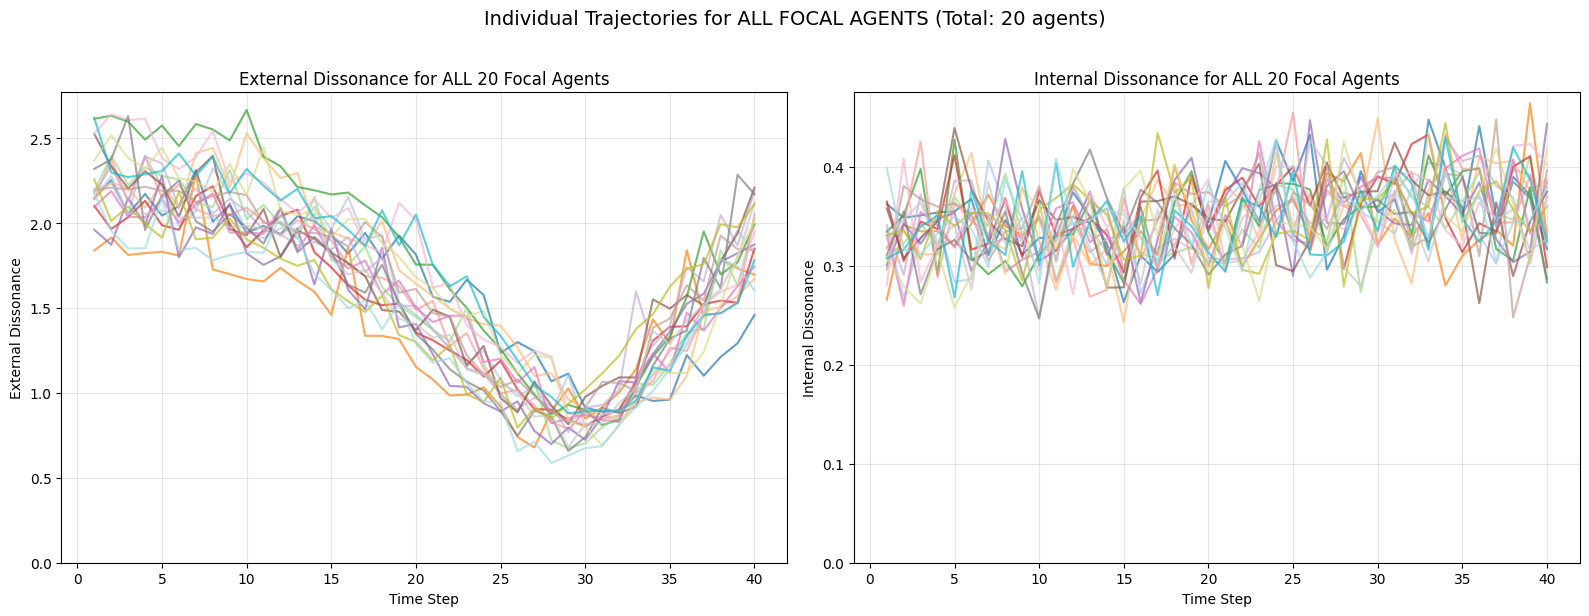

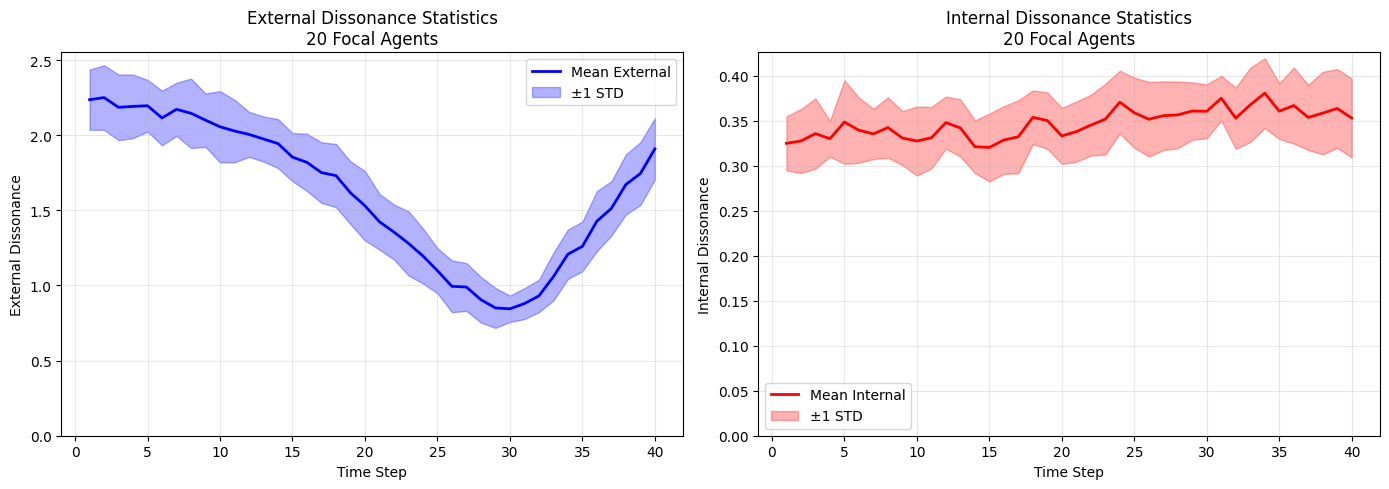

In [ ]:
def plot_simple_focal_individual_trajectories(history, parameters, agent_info):
    """
    Simple version: Plot individual agent trajectories for ALL focal agents
    (Similar to original plot_individual_trajectories but for ALL focal agents)
    """
    if not agent_info or 'focal_agents' not in agent_info:
        print("Warning: No focal agent information found.")
        return

    focal_agent_indices = agent_info['focal_agents']
    num_focal_agents = len(focal_agent_indices)

    if num_focal_agents == 0:
        print("Warning: No focal agents found.")
        return

    timesteps = [d['time'] for d in history]

    # Extract individual dissonance trajectories
    d_ext_individual_history = np.array([d['d_ext_individual'] for d in history]).T
    d_int_individual_history = np.array([d['d_int_individual'] for d in history]).T

    # Extract trajectories for ALL focal agents
    focal_d_ext_trajectories = d_ext_individual_history[focal_agent_indices]
    focal_d_int_trajectories = d_int_individual_history[focal_agent_indices]

    # Use ALL focal agents (no sampling)
    focal_to_plot = focal_agent_indices
    focal_trajectories_ext = focal_d_ext_trajectories
    focal_trajectories_int = focal_d_int_trajectories

    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Generate distinct colors for all focal agents
    if num_focal_agents <= 20:
        # Use tab20 colormap for up to 20 agents
        colors = plt.cm.tab20(np.linspace(0, 1, num_focal_agents))
    else:
        # Use hsv colormap for more than 20 agents
        colors = plt.cm.hsv(np.linspace(0, 1, num_focal_agents))

    # Plot External Dissonance for ALL focal agents
    for i, agent_idx in enumerate(focal_to_plot):
        ax1.plot(timesteps, focal_trajectories_ext[i],
                label=f'Agent {agent_idx}',
                alpha=0.7, linewidth=1.5, color=colors[i])
    ax1.set_title(f'External Dissonance for ALL {num_focal_agents} Focal Agents')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('External Dissonance')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)

    # Plot Internal Dissonance for ALL focal agents
    for i, agent_idx in enumerate(focal_to_plot):
        ax2.plot(timesteps, focal_trajectories_int[i],
                label=f'Agent {agent_idx}',
                alpha=0.7, linewidth=1.5, color=colors[i])
    ax2.set_title(f'Internal Dissonance for ALL {num_focal_agents} Focal Agents')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Internal Dissonance')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(bottom=0)

    plt.suptitle(f'Individual Trajectories for ALL FOCAL AGENTS (Total: {num_focal_agents} agents)',
                fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # Also create a summary statistics plot
    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 5))

    # Calculate mean and standard deviation across all focal agents
    focal_d_ext_mean = np.mean(focal_d_ext_trajectories, axis=0)
    focal_d_int_mean = np.mean(focal_d_int_trajectories, axis=0)
    focal_d_ext_std = np.std(focal_d_ext_trajectories, axis=0)
    focal_d_int_std = np.std(focal_d_int_trajectories, axis=0)

    # Plot mean with shaded standard deviation for external
    ax3.plot(timesteps, focal_d_ext_mean, label='Mean External', color='blue', linewidth=2)
    ax3.fill_between(timesteps,
                     focal_d_ext_mean - focal_d_ext_std,
                     focal_d_ext_mean + focal_d_ext_std,
                     alpha=0.3, color='blue', label='±1 STD')

    ax3.set_title(f'External Dissonance Statistics\n{num_focal_agents} Focal Agents')
    ax3.set_xlabel('Time Step')
    ax3.set_ylabel('External Dissonance')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(bottom=0)

    # Plot mean with shaded standard deviation for internal
    ax4.plot(timesteps, focal_d_int_mean, label='Mean Internal', color='red', linewidth=2)
    ax4.fill_between(timesteps,
                     focal_d_int_mean - focal_d_int_std,
                     focal_d_int_mean + focal_d_int_std,
                     alpha=0.3, color='red', label='±1 STD')

    ax4.set_title(f'Internal Dissonance Statistics\n{num_focal_agents} Focal Agents')
    ax4.set_xlabel('Time Step')
    ax4.set_ylabel('Internal Dissonance')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()

plot_simple_focal_individual_trajectories(history, parameters, agent_info)

Figure 3: Joint distribution for focal agents

/tmp/ipython-input-3702562645.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_joint.legend(loc='upper right', fontsize=9)


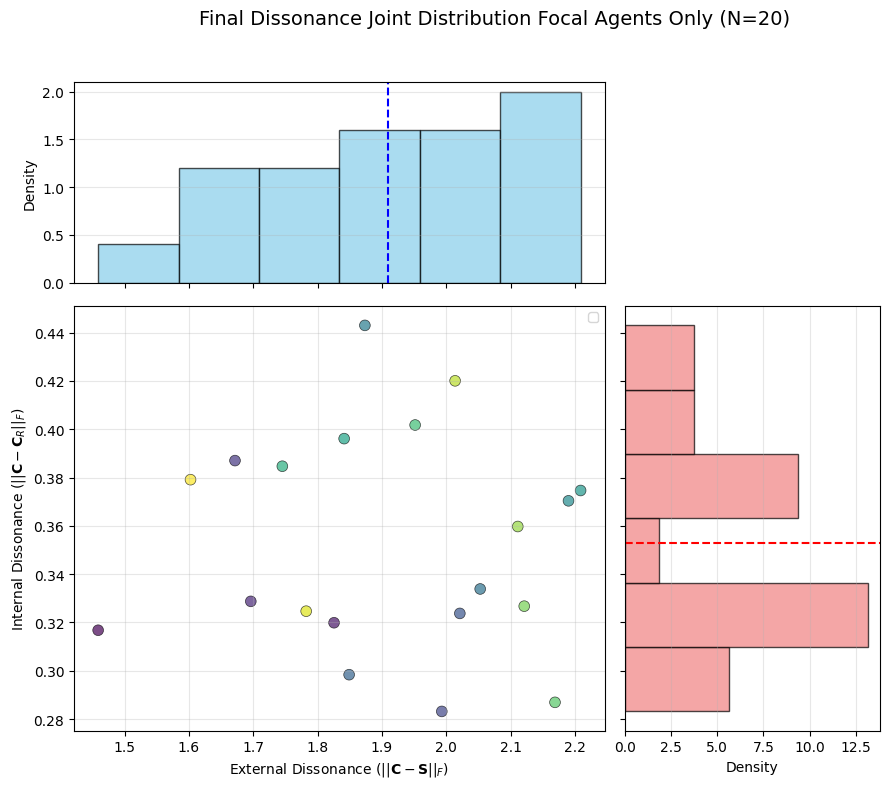

In [ ]:
def plot_focal_joint_dissonance_distribution(history, parameters, agent_info):
    """
    Plot joint dissonance distribution with marginal histograms for FOCAL AGENTS ONLY
    """
    if not agent_info or 'focal_agents' not in agent_info:
        print("Warning: No focal agent information found.")
        return

    focal_agent_indices = agent_info['focal_agents']
    num_focal_agents = len(focal_agent_indices)

    if num_focal_agents == 0:
        print("Warning: No focal agents found.")
        return

    # Extract individual dissonance trajectories for ALL agents
    d_ext_individual_history = np.array([d['d_ext_individual'] for d in history]).T
    d_int_individual_history = np.array([d['d_int_individual'] for d in history]).T

    # Extract only focal agents' data
    focal_d_ext_history = d_ext_individual_history[focal_agent_indices]
    focal_d_int_history = d_int_individual_history[focal_agent_indices]

    # Get final values for focal agents only
    final_d_ext = focal_d_ext_history[:, -1]
    final_d_int = focal_d_int_history[:, -1]

    # Calculate statistics for focal agents
    focal_ext_mean = np.mean(final_d_ext)
    focal_int_mean = np.mean(final_d_int)
    focal_ext_std = np.std(final_d_ext)
    focal_int_std = np.std(final_d_int)

    # Calculate correlation for focal agents
    correlation = np.corrcoef(final_d_ext, final_d_int)[0, 1]

    # Create figure and a GridSpec layout for the joint plot
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(3, 3)

    # Define the axes
    ax_joint = fig.add_subplot(gs[1:3, 0:2])
    ax_hist_x = fig.add_subplot(gs[0, 0:2], sharex=ax_joint)
    ax_hist_y = fig.add_subplot(gs[1:3, 2], sharey=ax_joint)

    # Remove tick labels from marginal plots
    ax_hist_x.tick_params(axis="x", labelbottom=False)
    ax_hist_y.tick_params(axis="y", labelleft=False)

    # Main Scatter Plot (Joint Distribution) for focal agents
    scatter = ax_joint.scatter(final_d_ext, final_d_int,
                              alpha=0.7, s=60,
                              c=np.arange(num_focal_agents),
                              cmap='viridis',
                              edgecolors='k', linewidth=0.5)


    ax_joint.set_xlabel(r'External Dissonance ($||\mathbf{C}-\mathbf{S}||_F$)')
    ax_joint.set_ylabel(r'Internal Dissonance ($||\mathbf{C}-\mathbf{C}_R||_F$)')
    ax_joint.grid(True, alpha=0.3)
    ax_joint.legend(loc='upper right', fontsize=9)

    # Marginal Histograms for focal agents
    bins = min(15, max(5, num_focal_agents // 3))  # Adaptive bin size

    # Top histogram (external dissonance distribution)
    ax_hist_x.hist(final_d_ext, bins=bins, color='skyblue',
                   edgecolor='black', alpha=0.7, density=True)
    ax_hist_x.axvline(focal_ext_mean, color='blue', linestyle='dashed', linewidth=1.5)
    ax_hist_x.set_ylabel('Density')
    ax_hist_x.grid(True, alpha=0.3, axis='y')

    # Right histogram (internal dissonance distribution)
    ax_hist_y.hist(final_d_int, bins=bins, orientation='horizontal',
                   color='lightcoral', edgecolor='black', alpha=0.7, density=True)
    ax_hist_y.axhline(focal_int_mean, color='red', linestyle='dashed', linewidth=1.5)
    ax_hist_y.set_xlabel('Density')
    ax_hist_y.grid(True, alpha=0.3, axis='x')

    # Remove the unused subplot
    fig.delaxes(fig.add_subplot(gs[0, 2]))

    # Add title with focal agent information
    plt.suptitle(f'Final Dissonance Joint Distribution Focal Agents Only (N={num_focal_agents})',
                fontsize=14, y=0.98)

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust for colorbar
    plt.show()

plot_focal_joint_dissonance_distribution(history, parameters, agent_info)

Figure 4 : fancy plot only focal

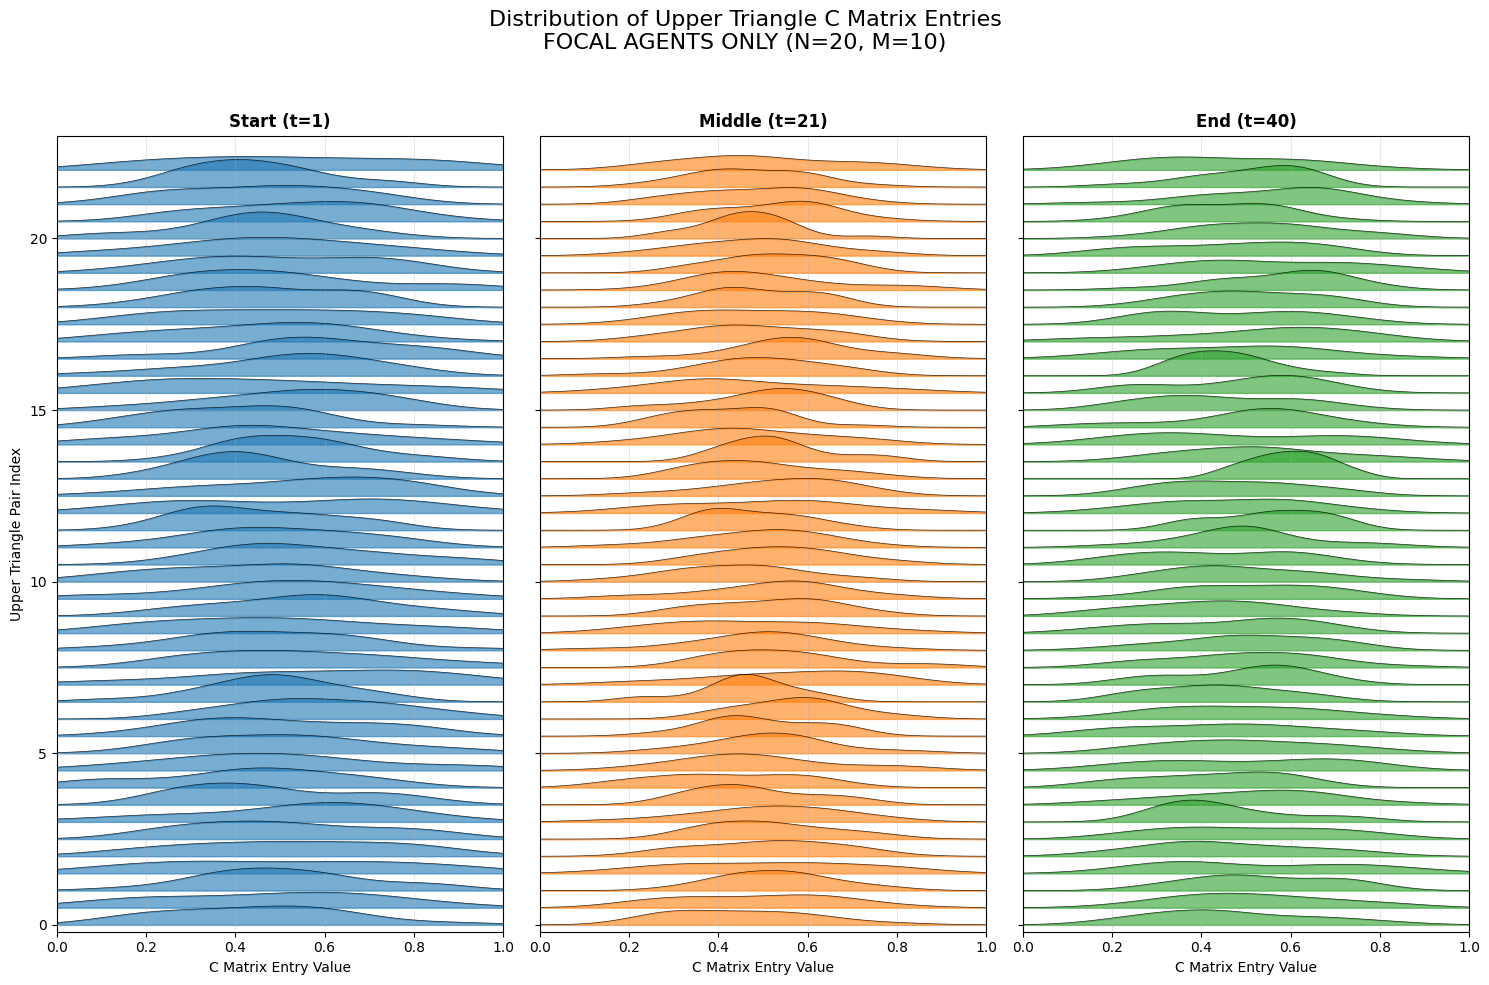

In [ ]:
def plot_focal_c_matrix_distribution(history, parameters, agent_info):
    """
    Plot C-matrix entry distribution (joy plot) for focal agents only.
    Handles the Object-to-Float conversion to prevent TypeError.
    """
    if not agent_info or 'focal_agents' not in agent_info:
        print("Warning: No focal agent information found.")
        return

    focal_agent_indices = agent_info['focal_agents']
    num_focal_agents = len(focal_agent_indices)

    if num_focal_agents == 0:
        print("Warning: No focal agents found.")
        return

    if 'C_matrices' not in history[0]:
        print("Skipping C matrix distribution plot (C matrices not available)")
        return

    M_TOPICS = parameters.get('M_TOPICS', 5)
    T_steps = len(history)

    times_to_plot = {
        'Start': 0,
        'Middle': T_steps // 2,
        'End': T_steps - 1
    }

    fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=True)
    fig.suptitle(f'Distribution of Upper Triangle C Matrix Entries\nFOCAL AGENTS ONLY (N={num_focal_agents}, M={M_TOPICS})', fontsize=16)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    num_upper_triangle_entries = (M_TOPICS * (M_TOPICS - 1)) // 2

    for col_idx, (time_name, time_idx) in enumerate(times_to_plot.items()):
        ax = axes[col_idx]

        # --- FIX: Force conversion to float64 here ---
        raw_C = history[time_idx]['C_matrices']
        focal_C_matrices = np.array(raw_C[focal_agent_indices], dtype=np.float64)

        upper_triangle_entries = []
        for i in range(M_TOPICS):
            for j in range(i + 1, M_TOPICS):
                # focal_C_matrices is (num_focal, M, M)
                # This grabs the (i, j) entry for all focal agents
                upper_triangle_entries.append(focal_C_matrices[:, i, j])

        upper_triangle_data = np.array(upper_triangle_entries) # Shape: (Entries, Agents)

        y_offset = 0.5
        x_range = np.linspace(0, 1, 100)
        max_density = 0
        all_kdes = []

        for entry_idx in range(num_upper_triangle_entries):
            entry_values = upper_triangle_data[entry_idx, :]

            # Remove NaNs safely now that it's a float array
            entry_values = entry_values[~np.isnan(entry_values)]

            # Only calculate KDE if there's variance in the data
            if len(entry_values) > 1 and np.std(entry_values) > 1e-6:
                kde = gaussian_kde(entry_values)
                density = kde(x_range)
                max_density = max(max_density, density.max())
                all_kdes.append((entry_idx, density))
            else:
                # Fallback for zero-variance data (e.g., all 0s or all 1s)
                all_kdes.append((entry_idx, np.zeros_like(x_range)))

        # Avoid division by zero if all densities are zero
        if max_density == 0: max_density = 1

        for i, (entry_idx, density) in enumerate(all_kdes):
            y_position = i * y_offset
            normalized_density = (density / max_density) * 0.8
            y_curve = normalized_density + y_position

            ax.fill_between(x_range, y_position, y_curve,
                          color=colors[col_idx], alpha=0.6)
            ax.plot(x_range, y_curve, color='black', linewidth=0.5, alpha=0.8)

        ax.set_title(f'{time_name} (t={history[time_idx]["time"]})', fontsize=12, fontweight='bold')
        ax.set_xlabel('C Matrix Entry Value')
        if col_idx == 0:
            ax.set_ylabel('Upper Triangle Pair Index')

        ax.set_xlim(0, 1)
        ax.set_ylim(-0.2, (num_upper_triangle_entries) * y_offset + 0.5)
        ax.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_focal_c_matrix_distribution(history, parameters, agent_info)

Figure 5: Matrix snap shot only focal

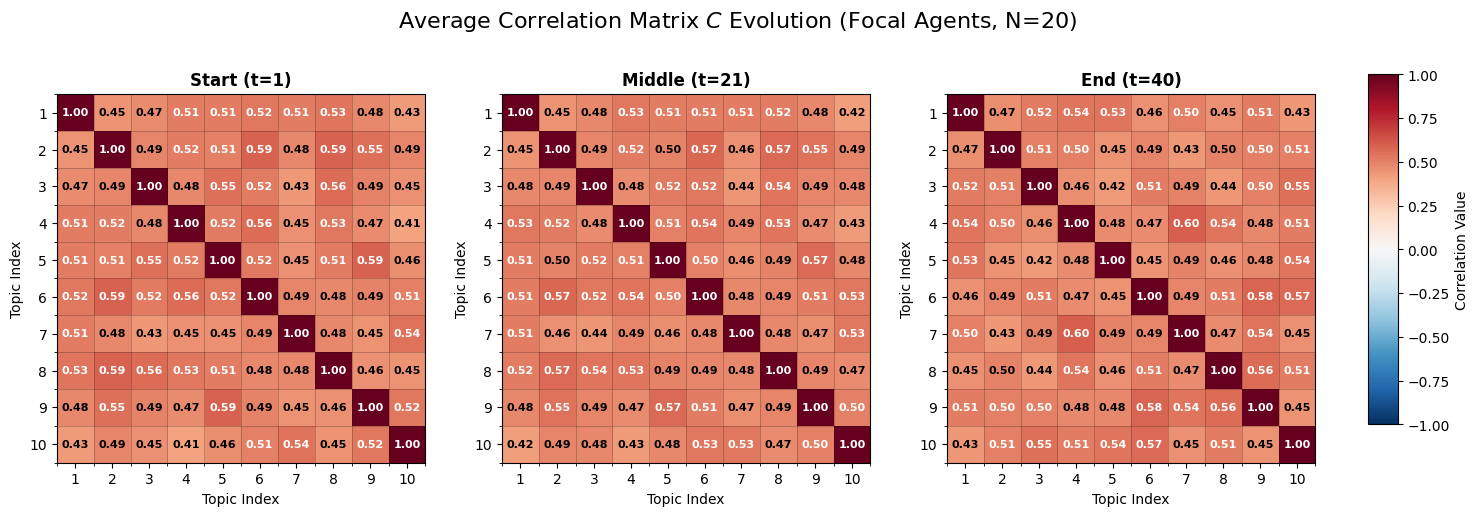

In [ ]:
def plot_focal_average_c_matrix_evolution(history, parameters, agent_info):
    """
    Plot average C matrix evolution over time for FOCAL AGENTS ONLY.
    Forces numeric conversion to solve 'dtype object' TypeError.
    """
    # 1. Validation & Variable Setup
    if not agent_info or 'focal_agents' not in agent_info:
        print("Warning: No focal agent information found.")
        return

    focal_agent_indices = agent_info['focal_agents']
    num_focal_agents = len(focal_agent_indices)

    # Fixed typo: num_focal_agaents -> num_focal_agents
    if num_focal_agents == 0:
        print("Warning: No focal agents found.")
        return

    if 'C_matrices' not in history[0]:
        print("Skipping C matrix evolution plot (C matrices not available)")
        return

    M_TOPICS = parameters.get('M_TOPICS', 5)
    T_steps = len(history)

    times_to_plot = {
        'Start': 0,
        'Middle': T_steps // 2,
        'End': T_steps - 1
    }

    # 2. Figure Setup
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Average Correlation Matrix $C$ Evolution (Focal Agents, N={num_focal_agents})', fontsize=16)

    vmin, vmax = -1, 1

    for col_idx, (time_name, time_idx) in enumerate(times_to_plot.items()):
        ax = axes[col_idx]

        # --- FIX: Force conversion to numeric float64 ---
        # history[time_idx]['C_matrices'] is often dtype=object here
        raw_C_all = history[time_idx]['C_matrices']

        # Slice only focal agents and force numeric type
        focal_C_matrices = np.array(raw_C_all[focal_agent_indices], dtype=np.float64)

        # Calculate average C matrix (Result is now a numeric M x M matrix)
        avg_C_matrix = np.mean(focal_C_matrices, axis=0)

        # 3. Plotting
        im = ax.imshow(avg_C_matrix, cmap='RdBu_r', vmin=vmin, vmax=vmax, aspect='equal')

        ax.set_title(f'{time_name} (t={history[time_idx]["time"]})', fontsize=12, fontweight='bold')
        ax.set_xlabel('Topic Index')
        ax.set_ylabel('Topic Index')

        # Grid and Ticks
        ax.set_xticks(np.arange(-0.5, M_TOPICS, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, M_TOPICS, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

        # Add text labels to each cell
        for i in range(M_TOPICS):
            for j in range(M_TOPICS):
                val = avg_C_matrix[i, j]
                # Dynamic text color for readability against heatmap
                text_color = 'white' if abs(val) > 0.5 else 'black'
                ax.text(j, i, f'{val:.2f}',
                        ha='center', va='center', color=text_color,
                        fontsize=8, fontweight='bold')

        ax.set_xticks(np.arange(M_TOPICS))
        ax.set_yticks(np.arange(M_TOPICS))
        ax.set_xticklabels(np.arange(1, M_TOPICS + 1))
        ax.set_yticklabels(np.arange(1, M_TOPICS + 1))

    # 4. Colorbar Layout
    plt.tight_layout(rect=[0, 0, 0.9, 0.92])
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Correlation Value')
    plt.show()

# Run the function
plot_focal_average_c_matrix_evolution(history, parameters, agent_info)

Following are broken, need to fix!


Figure 1 - Aggregate Dissonance and Reward

In [ ]:
def plot_aggregate_dissonance(history, parameters):
    """
    Plot 1a: Average Dissonance Over Time
    Plot 1b: Average Reward Over Time
    """
    timesteps = [d['time'] for d in history]
    d_ext_avg_history = [d['d_ext_avg'] for d in history]
    d_int_avg_history = [d['d_int_avg'] for d in history]
    reward_history = [d['reward_avg'] for d in history]

    # Plot 1a: Average Dissonance Over Time
    fig1a, ax1a = plt.subplots(figsize=(12, 5))
    ax1a.plot(timesteps, d_ext_avg_history, label='Average External Dissonance', color='blue', linewidth=3)
    ax1a.plot(timesteps, d_int_avg_history, label='Average Internal Dissonance', color='red', linewidth=3)
    ax1a.set_title('1a. Aggregate Cognitive Dissonance Over Time')
    ax1a.set_xlabel('Time Step')
    ax1a.set_ylabel('Dissonance (Frobenius Norm)')
    ax1a.legend()
    ax1a.grid(True, alpha=0.3)
    plt.show()

    # Plot 1b: Average Reward Over Time
    fig1b, ax1b = plt.subplots(figsize=(12, 3))
    ax1b.plot(timesteps[2:], reward_history[2:], label='Average Reward (Dissonance Reduction)', color='green')
    ax1b.set_title('1b. Average Reward Over Time')
    ax1b.set_xlabel('Time Step')
    ax1b.set_ylabel('Average Reward')
    ax1b.legend()
    ax1b.grid(True, alpha=0.3)
    plt.show()

# Run the function
plot_aggregate_dissonance(history, parameters)

Figure 2 - Individual Agent Trajectories

In [ ]:
def plot_individual_trajectories(history, parameters):
    """
    Plot individual agent trajectories for external and internal dissonance
    """
    N_AGENTS = parameters.get('N_AGENTS', len(history[0]['d_ext_individual']))
    NUM_AGENTS_TO_PLOT = min(20, N_AGENTS)

    timesteps = [d['time'] for d in history]
    d_ext_individual_history = np.array([d['d_ext_individual'] for d in history]).T
    d_int_individual_history = np.array([d['d_int_individual'] for d in history]).T

    # Select a few random agents for the individual trajectory plot
    np.random.seed(42)
    agent_indices = np.random.choice(N_AGENTS, NUM_AGENTS_TO_PLOT, replace=False)

    fig2, (ax2a, ax2b) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot External Dissonance for selected agents (ax2a)
    for i, agent_idx in enumerate(agent_indices):
        ax2a.plot(timesteps, d_ext_individual_history[agent_idx], label=f'Agent {agent_idx}', alpha=0.7)
    ax2a.set_title(f'2a. External Dissonance for {NUM_AGENTS_TO_PLOT} Sample Agents')
    ax2a.set_xlabel('Time Step')
    ax2a.set_ylabel('External Dissonance')
    ax2a.grid(True, alpha=0.3)
    #ax2a.legend(loc='upper right')

    # Plot Internal Dissonance for selected agents (ax2b)
    for i, agent_idx in enumerate(agent_indices):
        ax2b.plot(timesteps, d_int_individual_history[agent_idx], label=f'Agent {agent_idx}', alpha=0.7)
    ax2b.set_title(f'2b. Internal Dissonance for {NUM_AGENTS_TO_PLOT} Sample Agents')
    ax2b.set_xlabel('Time Step')
    ax2b.set_ylabel('Internal Dissonance')
    ax2b.grid(True, alpha=0.3)
    #ax2b.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Run the function
plot_individual_trajectories(history, parameters)

Figure 3 - Joint Dissonance Distribution

In [ ]:
def plot_joint_dissonance_distribution(history, parameters):
    """
    Plot joint dissonance distribution with marginal histograms
    """
    d_ext_individual_history = np.array([d['d_ext_individual'] for d in history]).T
    d_int_individual_history = np.array([d['d_int_individual'] for d in history]).T

    final_d_ext = d_ext_individual_history[:, -1]
    final_d_int = d_int_individual_history[:, -1]

    # Create figure and a GridSpec layout for the joint plot
    fig3 = plt.figure(figsize=(8, 8))
    gs = fig3.add_gridspec(3, 3)

    # Define the axes
    ax_joint = fig3.add_subplot(gs[1:3, 0:2])
    ax_hist_x = fig3.add_subplot(gs[0, 0:2], sharex=ax_joint)
    ax_hist_y = fig3.add_subplot(gs[1:3, 2], sharey=ax_joint)

    # Remove tick labels from marginal plots
    ax_hist_x.tick_params(axis="x", labelbottom=False)
    ax_hist_y.tick_params(axis="y", labelleft=False)

    # 3a. Main Scatter Plot (Joint Distribution/Phase Space)
    ax_joint.scatter(final_d_ext, final_d_int, alpha=0.6, s=50, edgecolors='k', color='darkslategray')
    ax_joint.axvline(np.mean(final_d_ext), color='blue', linestyle='--', linewidth=1, label=f'Mean Ext.: {np.mean(final_d_ext):.2f}')
    ax_joint.axhline(np.mean(final_d_int), color='red', linestyle='--', linewidth=1, label=f'Mean Int.: {np.mean(final_d_int):.2f}')

    ax_joint.set_xlabel(r'External Dissonance ($||\mathbf{C}-\mathbf{S}||_F$)')
    ax_joint.set_ylabel(r'Internal Dissonance ($||\mathbf{C}-\mathbf{C}_R||_F$)')
    ax_joint.grid(True, alpha=0.3)
    ax_joint.legend(loc='upper right')

    # 3b. Marginal Histograms
    bins = 15
    ax_hist_x.hist(final_d_ext, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
    ax_hist_x.set_title('3. Final Dissonance Joint Distribution and Marginal Histograms', fontsize=14, pad=20)
    ax_hist_x.axvline(np.mean(final_d_ext), color='blue', linestyle='dashed', linewidth=1)
    ax_hist_x.set_ylabel('Agent Count')

    ax_hist_y.hist(final_d_int, bins=bins, orientation='horizontal', color='lightcoral', edgecolor='black', alpha=0.7)
    ax_hist_y.axhline(np.mean(final_d_int), color='red', linestyle='dashed', linewidth=1)
    ax_hist_y.set_xlabel('Agent Count')

    fig3.delaxes(fig3.add_subplot(gs[0, 2]))
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Run the function
plot_joint_dissonance_distribution(history, parameters)

Figure 4 - C-Matrix Entry Distribution

In [ ]:
def plot_c_matrix_distribution(history, parameters):
    """
    Plot C-matrix entry distribution joy plot (upper triangle only)
    """
    # Check if C matrices are available
    has_C_matrices = 'C_matrices' in history[0]
    if not has_C_matrices:
        print("Skipping C matrix distribution plot (C matrices not available)")
        return

    N_AGENTS = parameters.get('N_AGENTS', len(history[0]['d_ext_individual']))
    M_TOPICS = parameters.get('M_TOPICS', 5)
    T_steps = len(history)

    times_to_plot = {
        'Start': 0,
        'Middle': T_steps // 2 - 1,
        'End': T_steps - 1
    }

    fig4, axes = plt.subplots(1, 3, figsize=(15, 10))
    fig4.suptitle(f'4. Distribution of Upper Triangle C Matrix Entries Across All Agents (N={N_AGENTS}, M={M_TOPICS})', fontsize=16)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    num_upper_triangle_entries = (M_TOPICS * (M_TOPICS - 1)) // 2

    for col_idx, (time_name, time_idx) in enumerate(times_to_plot.items()):
        ax = axes[col_idx]
        C_matrices = history[time_idx]['C_matrices']

        upper_triangle_entries = []
        for i in range(M_TOPICS):
            for j in range(i + 1, M_TOPICS):
                upper_triangle_entries.append(C_matrices[:, i, j])

        upper_triangle_data = np.array(upper_triangle_entries)

        y_offset = 0.5
        x_range = np.linspace(0, 1, 100)

        max_density = 0
        all_kdes = []

        for entry_idx in range(num_upper_triangle_entries):
            entry_values = upper_triangle_data[entry_idx, :]
            entry_values = entry_values[~np.isnan(entry_values)]
            if len(entry_values) > 1:
                kde = gaussian_kde(entry_values)
                density = kde(x_range)
                max_density = max(max_density, density.max())
                all_kdes.append((entry_idx, density))

        for i, (entry_idx, density) in enumerate(all_kdes):
            y_position = i * y_offset
            normalized_density = density / max_density * 0.8
            y_curve = normalized_density + y_position

            ax.fill_between(x_range, y_position, y_curve,
                          color=colors[col_idx], alpha=0.6)
            ax.plot(x_range, y_curve, color='black', linewidth=0.5, alpha=0.8)

        ax.set_title(f'{time_name} (t={time_idx+1})', fontsize=12, fontweight='bold')
        ax.set_xlabel('C Matrix Entry Value')
        if col_idx == 0:
            ax.set_ylabel('Upper Triangle Entry Index')

        ax.set_xlim(0, 1)
        ax.set_ylim(-0.5, len(all_kdes) * y_offset + 0.5)
        ax.grid(True, alpha=0.3)

        mean_all = np.mean(upper_triangle_data)
        std_all = np.std(upper_triangle_data)
        ax.axvline(mean_all, color='red', linestyle='--', linewidth=1, alpha=0.8)
        ax.text(0.02, 0.98, f'Mean: {mean_all:.3f}\nStd: {std_all:.3f}\nEntries: {num_upper_triangle_entries}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Run the function
plot_c_matrix_distribution(history, parameters)

Figure 5 - Average C Matrix Evolution

In [ ]:
def plot_average_c_matrix_evolution(history, parameters):
    """
    Plot average C matrix evolution over time
    """
    # Check if C matrices are available
    has_C_matrices = 'C_matrices' in history[0]
    if not has_C_matrices:
        print("Skipping C matrix evolution plot (C matrices not available)")
        return

    N_AGENTS = parameters.get('N_AGENTS', len(history[0]['d_ext_individual']))
    M_TOPICS = parameters.get('M_TOPICS', 5)
    T_steps = len(history)

    times_to_plot = {
        'Start': 0,
        'Middle': T_steps // 2 - 1,
        'End': T_steps - 1
    }

    fig5, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig5.suptitle(f'5. Average Correlation Matrix $C$ Evolution (N={N_AGENTS}, M={M_TOPICS})', fontsize=16)

    vmin, vmax = -1, 1

    for col_idx, (time_name, time_idx) in enumerate(times_to_plot.items()):
        ax = axes[col_idx]
        C_matrices = history[time_idx]['C_matrices']
        avg_C_matrix = np.mean(C_matrices, axis=0)

        im = ax.imshow(avg_C_matrix, cmap='RdBu_r', vmin=vmin, vmax=vmax, aspect='equal')

        ax.set_title(f'{time_name} (t={time_idx+1})', fontsize=12, fontweight='bold')
        ax.set_xlabel('Topic Index')
        ax.set_ylabel('Topic Index')

        ax.set_xticks(np.arange(-0.5, M_TOPICS, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, M_TOPICS, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5, alpha=0.3)

        for i in range(M_TOPICS):
            for j in range(M_TOPICS):
                text = ax.text(j, i, f'{avg_C_matrix[i, j]:.2f}',
                              ha='center', va='center', color='black',
                              fontsize=8, fontweight='bold')

        ax.set_xticks(np.arange(M_TOPICS))
        ax.set_yticks(np.arange(M_TOPICS))
        ax.set_xticklabels(np.arange(1, M_TOPICS + 1))
        ax.set_yticklabels(np.arange(1, M_TOPICS + 1))

    plt.tight_layout(rect=[0, 0, 0.9, 0.92])
    cbar_ax = fig5.add_axes([0.92, 0.15, 0.02, 0.7])
    fig5.colorbar(im, cax=cbar_ax, label='Correlation Value')
    plt.show()

# Run the function
plot_average_c_matrix_evolution(history, parameters)